## Solaris Multimodal Preprocessing Library
# Tutorial Part 2: Branching

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

plt.rcParams['figure.figsize'] = [4, 4]
datadir = '../../../solaris/data/preproc_tutorial'

/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorf

For the second example of the preprocessing library, let's implement a basic pansharpening algorithm.  In pansharpening, a high-resolution grayscale image ("panchromatic") is combined with a low-resolution color image of the same region ("multispectral") to create a high-resolution color image ("pansharpened").  As always, a good starting point is to imagine the flowchart of the desired task:

<img src="../../../solaris/data/preproc_tutorial/example2flowchart.png">

For the purpose of this tutorial, the details of how this works are not important, nor is the fact that better pansharpening algorithms are available.  What matters is that different branches split apart and come together in this flowchart, making this a more complex workflow than the simple pipeline of Example 1.

The code will be set up as a reusable class, following the template in the Example 1 Follow-Up.

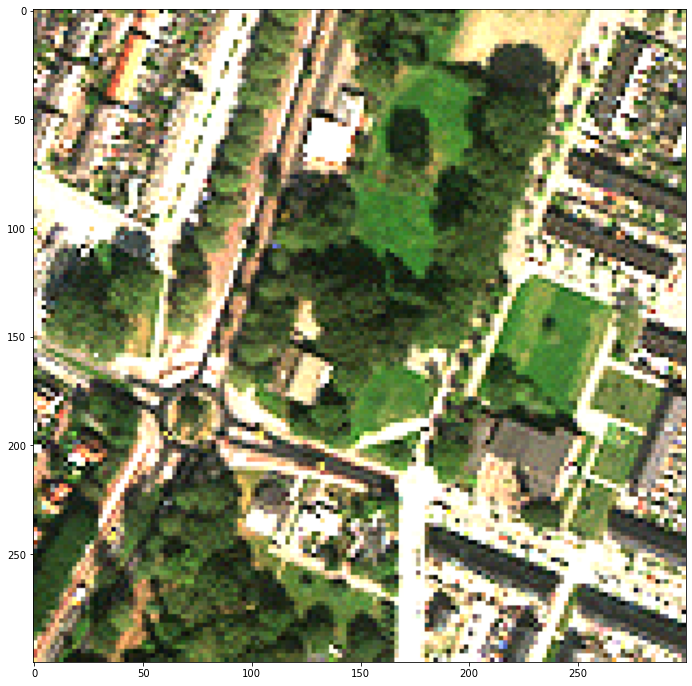

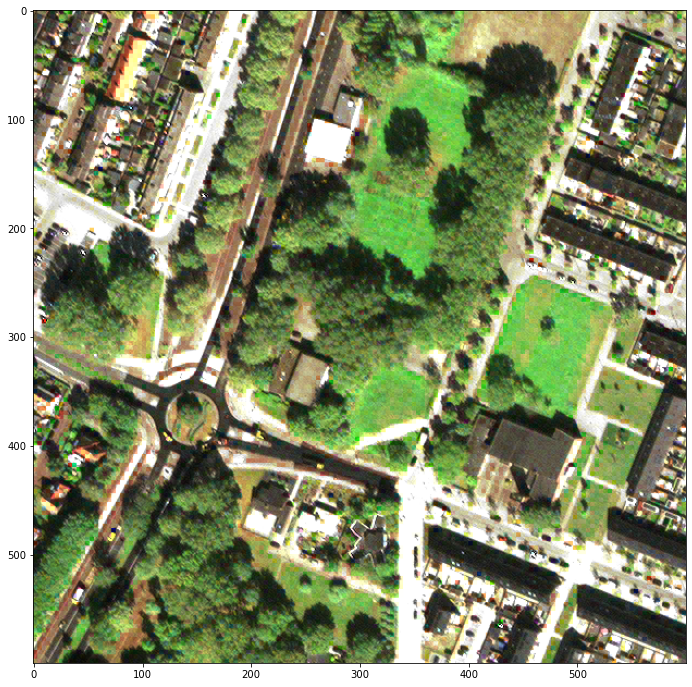

In [7]:
class Pansharpening(pipesegment.PipeSegment):
    def __init__(self, ms_path, pan_path, output_path):
        super().__init__()
        load_ms = image.LoadImage(ms_path) \
            * image.ShowImage(bands=[2,1,0], vmin=0, vmax=250, width=12)
        resize_ms = image.Resize(600, 600)
        color_ms = optical.RGBToHSV(rband=2, gband=1, bband=0)
        load_pan = image.LoadImage(pan_path)
        stack1 = image.MergeToStack()
        get_hs = image.SelectBands((0, 1))
        get_v = sar.BandMath(lambda x: x[3] * np.mean(x[2]) / np.mean(x[3]))
        stack2 = image.MergeToStack()
        color_output = optical.HSVToRGB(hband=0, sband=1, vband=2) \
            * image.ShowImage(vmin=0, vmax=250, width=12)
        save_output = image.SaveImage(output_path)
        self.feeder = (load_ms * resize_ms * color_ms + load_pan) * stack1 \
            * (get_hs + get_v) * stack2 * color_output * save_output

ms_path = os.path.join(datadir, 'ms1.tif')
pan_path = os.path.join(datadir, 'pan1.tif')
output_path = os.path.join(datadir, 'output2.tif')
pansharpen = Pansharpening(ms_path, pan_path, output_path)
pansharpen()

The important thing to notice here is the `+` signs in the step specifying how all the parts are wired together:

In [3]:
#        self.feeder = (load_ms * resize_ms * color_ms + load_pan) * stack1 \
#            * (get_hs + get_v) * stack2 * color_output * save_output

Two objects or pipelines connected by a `+` sign can get their input from the same place and/or send their output to the same place.  For example, the section `stack1 * (get_hs + get_v) * stack2` means that the output of `stack1` is fed into both `get_hs` and `get_v`, while the outputs of both are in turn fed into `stack2`.  Many classes in `preproc.image`, `preproc.sar`, and `preproc.optical` expect a single image as input, but `MergeToStack` expects a tuple of images, and the `+` sign combines the two pipelines' outputs into a tuple.

Notice that two different `MergeToStack` objects were defined in the code (`stack1` and `stack2`).  In contrast, if the same variable appears twice in the expression, the software assumes that both references refer to the exact same block in the flowchart (its input may be specified at either place it appears, or redundantly at both -- they just can't contradict each other).  Sometimes multiple references to the same block are exactly what we want.  But here we had two different blocks that just happened to be of the same class, so two different objects had to be instantiated.

This notation for building up workflows with `*` and `+` symbols is very flexible.  Any directed acyclic graph (i.e., any flowchart without loops) can be defined this way.  The `preproc.pipesegment` module includes classes to handle cycles, but in practice that's rarely needed.

*Technical side note*:  In this example, it's assumed that we knew in advance how big the panchromatic image was, so the arguments to the `Resize` object could be hardcoded.  However, if we need the code to work for any image size, we could wrap the `image.Resize` class with a `pipesegment.PipeArgs` class to pipe in constructor arguments at runtime.

# Example 2 Follow-Up: Parallel Processing

It's often necessary to repeat the same analysis on many images.  For example, perhaps a large image has been tiled into thousands of small ones, and we want to do the same image processing for each tile.  On a multicore computer, there can be a speed improvement from running a number of jobs in parallel.

The classes in the `preproc` library are `PipeSegment` subclasses.  They inherit a method called `parallel` that handles parallel processing automatically.  Because user-defined classes also inherit from `PipeSegment`, they have the same method as well.

The code below uses the `parallel` method inherited by the `Pansharpening` class in Example 2 to pansharpen three images.  On a multicore computer, up to three cores are used at once.

In [4]:
#Specify all the file paths
ms_paths = [os.path.join(datadir, file) for file in ['ms1.tif', 'ms2.tif', 'ms3.tif']]
pan_paths = [os.path.join(datadir, file) for file in ['pan1.tif', 'pan2.tif', 'pan3.tif']]
output_paths = [os.path.join(datadir, file) for file in ['output2a.tif', 'output2b.tif', 'output2c.tif']]
input_args = list(zip(ms_paths, pan_paths, output_paths))
print(input_args)

#Run the jobs in parallel
Pansharpening.parallel(input_args)

[('../../../solaris/data/preproc_tutorial/ms1.tif', '../../../solaris/data/preproc_tutorial/pan1.tif', '../../../solaris/data/preproc_tutorial/output2a.tif'), ('../../../solaris/data/preproc_tutorial/ms2.tif', '../../../solaris/data/preproc_tutorial/pan2.tif', '../../../solaris/data/preproc_tutorial/output2b.tif'), ('../../../solaris/data/preproc_tutorial/ms3.tif', '../../../solaris/data/preproc_tutorial/pan3.tif', '../../../solaris/data/preproc_tutorial/output2c.tif')]
